In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image

In [2]:
def show_img(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def show_plt_img(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
def print_max_min_median(M):
    print(f"max={M.max()}, min={M.min()}, median={np.median(M)}")

### We perform the proposed algorithm on endoscopic images under design parameters α = 0.05, β1 ∈ [1, 5], β2 = 0.1, and τ ∈ [0.01, 0.1], and on natural images under design parameters α = 0.1, τ = 0.01, β1 = 3, and β2 = 0.1.

In [3]:
alpha = 0.1
theta = 0.01
sigma = 0.01
B1 = 3
B2 = 0.1 

In [4]:
def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

image = Image.open('fish.ppm')
new_image = make_square(image)
new_image.save('fish_square.ppm', 'PPM')

max=0.9450980424880981, min=0.0, median=0.03529411926865578


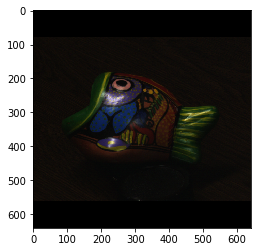

In [5]:
img = cv2.imread('fish_square.ppm').astype('float32') / 255.0
# img = cv2.imread('fish.ppm').astype('float32') / 255.0
print_max_min_median(img)
show_plt_img(img)
# show_img(img)


### Compute H(x); S(x); V(x)g by HSV transformation

max=0.9647058844566345, min=0.0, median=0.05882352963089943


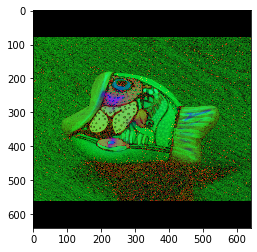

In [6]:
hsv_img = cv2.cvtColor(cv2.imread('fish_square.ppm'), cv2.COLOR_BGR2HSV).astype('float32') / 255.0
# hsv_img = cv2.cvtColor(cv2.imread('fish.ppm'), cv2.COLOR_BGR2HSV).astype('float32') / 255.0
print_max_min_median(hsv_img)
H, S, V = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
plt.imshow(hsv_img)
# show_img(hsv_img)

### Compute highlight detection sets by (8) and (9)


In [7]:
def show_with_mask(img, mask):
    coef_indxs = np.copy(mask)
    coef_indxs[coef_indxs == True] = 1
    coef_indxs[coef_indxs == False] = 0
    _3d_coef_indxs = np.repeat(coef_indxs[:, :, np.newaxis], 3, axis=2)
    plt.imshow(img * _3d_coef_indxs)

#### 8 $X_{SV}$(x) = {x| S(x) < α; V(x) > 1 − α}

In [8]:
X_SV = np.array(S < alpha) | np.array(V > (1 - alpha))

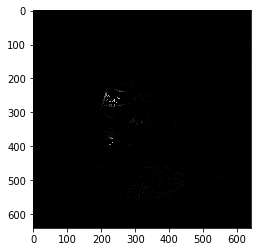

In [9]:
show_with_mask(img, X_SV)

#### 9 $X_G(x) = \{x|G(x) ≥ τ \}$

gradient magnitude of dark-channel image $\hat{I}(x) = min_{c∈{r,g,b}} I_c(x)$

In [10]:
I_b, I_g, I_r = cv2.split(img)
I_gmd = np.minimum(I_b, I_g, I_r)
print_max_min_median(I_gmd)

max=0.8117647171020508, min=0.0, median=0.0313725508749485


$G(x) =\frac{\sqrt{(\hat{I}(x+1,y)−\hat{I}(x−1,y))^2+(\hat{I}(x,y+1)−\hat{I}(x,y−1))^2}}{2}$


In [11]:
%%time
def check_bound(x, upper_bound):
    b1 = x - 1 > 0
    b2 = x + 1 < upper_bound
    return b1 and b2

G = np.copy(I_gmd)
for y in range(I_gmd.shape[0]):
    for x in range(I_gmd.shape[1]):
        if not check_bound(x, I_gmd.shape[1]) or  not check_bound(y, I_gmd.shape[0]):
            continue
        
        G[y, x] = np.sqrt( ( I_gmd[y, x+1] - I_gmd[y, x-1] ) ** 2  +  ( I_gmd[y+1, x] - I_gmd[y-1, x] ) ** 2 ) / 2

Wall time: 2.88 s


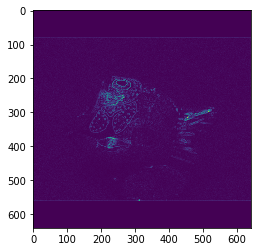

In [12]:
plt.imshow(G)

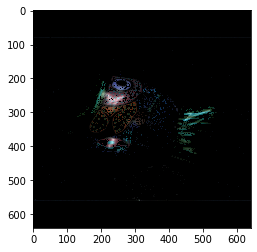

In [13]:
X_G = np.array(G >= theta)
show_with_mask(img, X_G)

### Compute Hue estimate $H^∗$(x) by (11)
### Compute Saturation estimate $S^∗$(x) by (12)

#### We propose a joint HSV and RGB-space detection set as below
#### $X_{SVG}(x) = X_{SV}(x) \cup X_G(x)$

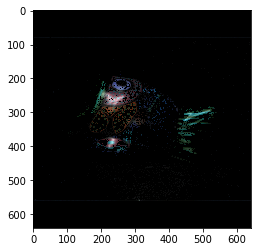

In [14]:
X_SVG = X_SV | X_G
show_with_mask(img, X_SVG)

$\begin{aligned} w_{S V G}(\mathbf{x}) &=\left\{\begin{array}{ll}\alpha, & \mathbf{x} \in X_{S V G}(\mathbf{x}) \\ 1, & \text {else}\end{array}\right.\\ 
\end{aligned}$   $~~~~~\mathbf{(13)}$

In [15]:
W_svg_matrix = np.ones(X_SVG.shape).astype('float32')
W_svg_matrix[X_SVG == True] = alpha
W_svg_matrix[X_SVG == False] = 1.0
np.unique(W_svg_matrix)

array([0.1, 1. ], dtype=float32)

### _____

$\begin{aligned} w_{H S}(\mathbf{x}, \mathbf{u})=e^{\left(\frac{-(\mathbf{H}(\mathbf{x})-\mathbf{H}(\mathbf{u}))^{2}}{\sigma^{2}}\right.} e^{\left.-(1-\mathbf{S}(\mathbf{u}))^{2}\right)} \end{aligned}$

### _____

$\mathbf{H}^{*}(x)=\frac{1}{\sum_{u \in \Omega(\mathbf{x})} w_{S V G}(\mathbf{u})} \sum_{u \in \Omega(\mathbf{x})} \mathbf{H}(\mathbf{u}) w_{S V G}(u)$     $~~~~~\mathbf{(11)}$

$\mathbf{S}^{*}(x)=\frac{1}{\sum_{u \in \Omega(\mathbf{x})} w_{H S}(\mathbf{x}, \mathbf{u})} \sum_{u \in \Omega(\mathbf{x})} \mathbf{S}(\mathbf{u}) w_{H S}(\mathbf{x}, \mathbf{u})$    $~~~~~\mathbf{(12)}$

In [16]:
def calc_size(point, shape, window_size):
    result = [0, 0, 0, 0]
    y, x = point
    edge = (window_size - 1) // 2
    result[0] = max(y - edge, 0)
    result[1] = min(shape[0], y + edge) 
    
    result[2] = max(x - edge, 0) 
    result[3] = min(x + edge, shape[1]) 
    return result 

def get_part(size, matrix):
    return matrix[size[0] : size[1], size[2] : size[3]]

def get_whs(H_x, H_window, S_window):
    part1 = (-(H_x - H_window) ** 2) / (sigma ** 2)
#     part2 = - (1 - S_window ** 2)
    part2 =  - (1 - S_window) ** 2
    return np.exp(part1) * np.exp(part2)
#     return np.exp(part1 * np.exp(part2))
    #     mb mistake in paper


In [17]:
%%time
window_size = 7
# H_11 = np.zeros(H.shape).astype('float32')
# H_12 = np.zeros(S.shape).astype('float32')
# H_11 = np.ones(H.shape).astype('float32')
# H_12 = np.ones(S.shape).astype('float32')
H_11 = np.copy(H)
S_12 = np.copy(S)
n = 0
for y in range(X_SVG.shape[0]):
    for x in range(X_SVG.shape[1]):
        if X_SVG[y, x] == True:
            n+=1
            size = calc_size((y, x), X_SVG.shape, window_size)
#             H_window = get_part(size, H)
#             S_window = get_part(size, S)  
            H_window = get_part(size, H_11)
            S_window = get_part(size, S_12)
           
            wsvg = get_part(size, W_svg_matrix)
            H_svg = H_window * wsvg
            H_11[y, x] = (1 / wsvg.sum()) * H_svg.sum()
            
            whs = get_whs(H[y, x], H_window, S_window)
            S_whs = whs * S_window
#             if whs.sum() ==0:
#                 print(f"{x} -- {y}")
#                 print(f"size = {size}")
#                 print(f"whs  = {whs}")
#                 print(f"part1 = {(-(H[y, x] - H_window) ** 2) / (sigma ** 2)}")
#                 print(f"e1 = {np.exp((-(H[y, x] - H_window) ** 2) / (sigma ** 2))}")
#                 print(f"part2 = {- (1 - S_window) ** 2}")
#                 print(f"e2 = {np.exp(- (1 - S_window) ** 2)}")
#                 print(f"window H {get_part(size, H_11)}")
#                 print(f"window S {get_part(size, S_12)}")
#                 print(f"Hy x {H[y, x]}")
#                 print(H_window)
#                 print(S_window)
#                 break
            if whs.sum() == 0:
                S_12[y,x] = 1.0
            else:
                S_12[y, x] = (1 / whs.sum()) * S_whs.sum()
n

Wall time: 5.61 s


133435

In [18]:
np.unique(X_SVG.astype('float32'))

array([0., 1.], dtype=float32)

In [19]:
mask = X_SVG.astype('float32')
# _hsv_new= cv2.inpaint(cv2.merge([H_11, S_12, O]).astype('uint8')*255, cv2.merge([mask,mask, mask]).astype('uint8')*255, 3, cv2.INPAINT_TELEA)
_H = cv2.inpaint(H.astype('uint8')*255, mask.astype('uint8')*255, 3, cv2.INPAINT_TELEA).astype('float32') / 255.0
# _H = cv2.inpaint(H_11, mask, 3, cv2.INPAINT_TELEA)

In [20]:
np.unique(_H)

array([0.], dtype=float32)

In [21]:
O = np.ones(H.shape).astype('float32')
_hsv_new =  cv2.merge([H_11, S_12, O])
# _hsv_new =  cv2.merge([H_11, S_12, V])
# _hsv_new =  cv2.merge([H * H_11,S* S_12, V])
# _hsv_new =  cv2.merge([H,S, V])

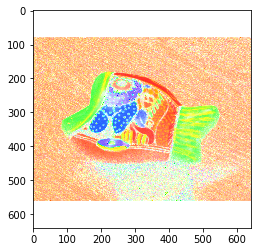

In [41]:
_hsv_new =  cv2.merge([H_11, S_12, O])
rgb_new_hsv = cv2.cvtColor((_hsv_new * 255).astype('uint8'), cv2.COLOR_HSV2RGB).astype('float32') / 255.0
plt.imshow(rgb_new_hsv)

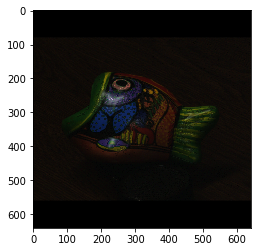

In [54]:
V_m = np.copy(V)
V_m[X_SVG] *= 0.6
V3 = cv2.merge([V_m,V_m,V_m])
plt.imshow(V3 * rgb_new_hsv)

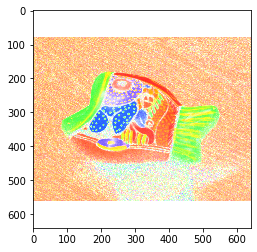

In [23]:
_hsv_new =  cv2.merge([H, S, O])
rgb_new_hsv = cv2.cvtColor((_hsv_new * 255).astype('uint8'), cv2.COLOR_HSV2RGB).astype('float32') / 255.0
plt.imshow(rgb_new_hsv)

In [24]:
I_Dr,I_Dg,I_Db = cv2.split(rgb_new_hsv)
I_DV = np.maximum(I_Dr,I_Dg,I_Db)
__img =  cv2.merge([I_DV* I_Dr, I_DV* I_Dg, I_DV* I_Db])

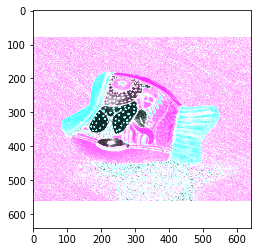

In [25]:
# rgb_new_hsv = cv2.cvtColor((__img * 255).astype('uint8'), cv2.COLOR_HSV2RGB).astype('float32') / 255.0
plt.imshow(__img)

### Compute diffuse chromaticity estimate by (15)

$\Lambda^{*}(\mathbf{x})=\varphi^{-1}\left(I_{H}^{*}, I_{S}^{*}, 1\right)$  

where $\varphi^{-1}$  is the inverse transformation from HSV color
space to RGB color space

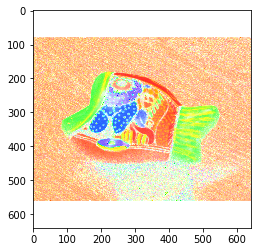

In [106]:
O = np.ones(H.shape).astype('float32')
_hsv_new =  cv2.merge([H_11, S_12, O])
_diff_chrom = cv2.cvtColor((_hsv_new * 255).astype('uint8'), cv2.COLOR_HSV2RGB).astype('float32') / 255.0
plt.imshow(_diff_chrom)
# show_img(_diff_chrom)

### Compute $m^∗_d$(x) by updating algorithm (25)

\begin{array}{l}
m_{d}^{k+1}(\mathbf{x})=P_{\Omega_{1}}\left[m_{d}^{k}(\mathbf{x})-h_{k} \frac{\partial E}{\partial m_{d}}\left(m_{d}^{k}(\mathbf{x}), m_{s}^{k}(\mathbf{x}), \mathbf{q}^{k}(\mathbf{x})\right)\right] \\
m_{s}^{k+1}(\mathbf{x})=P_{\Omega_{2}}\left[m_{s}^{k}(\mathbf{x})-h_{k} \frac{\partial E}{\partial m_{s}}\left(m_{d}^{k}(\mathbf{x}), m_{s}^{k}(\mathbf{x}), \mathbf{p}^{k}(\mathbf{x})\right)\right] \\
\mathbf{p}^{k+1}(\mathbf{x})=P_{\Omega_{3}}\left[\mathbf{p}^{k}(\mathbf{x})-h_{k} \beta_{2} \nabla m_{s}^{k}(\mathbf{x})\right] \\
\mathbf{q}^{k+1}(\mathbf{x})=\mathbf{q}^{k}(\mathbf{x})-h_{k} \beta_{1}\left(\nabla m_{d}^{k}(\mathbf{x})-\mathbf{q}^{k}(\mathbf{x})\right)
\end{array}

In [27]:
def P1(u):
    u[u < 0] = 0
    u[u > 1] = 1
    return u

def P2(u):
    u[u < 0] = 0
    u[u > 1] = 1
    return u

def P3(u):
    u[u < -1] = -1
    u[u > 1] = 1
    return u

In [28]:
def gen_1(shape):
    return (np.random.rand(*shape) * 0.001).astype('float32')
#     return np.random.choice(np.arange(0.3, 0.8, 0.001), shape)

def gen_2(shape):
    return (np.random.choice(np.arange(-1, 1, 0.001), shape)* 0.001).astype('float32')

When the highlight region is very small,
 is chosen to be 0. Otherwise,  is in general chosen as
the mean intensity of the neighborhood around the highlight
region

modification 1 -e only for hihlight, 1 otherwise

In [109]:
_Gamma = np.ones(img.shape).astype('float32')
_Gamma[:,:,0] = 1.0 - cv2.blur(I_r, (3,3))
_Gamma[:,:,0][~X_SVG] = 1.0
_I = img

In [110]:
_I.dtype, _Gamma.dtype

(dtype('float32'), dtype('float32'))

In [122]:
shape = img.shape
_m_d, _m_s = gen_1(shape), gen_1(shape)
_p_x, _p_y  = gen_2(shape), gen_2(shape)
_q_x, _q_y  = gen_2(shape), gen_2(shape)
h = 0.005

In [123]:
%%time
for color in range(3):
    m_d, m_s  = _m_d[:, :, color], _m_s[:, :, color]
    p_x, p_y  = _p_x[:, :, color], _p_y[:, :, color]
    q_x, q_y  = _q_x[:, :, color], _q_y[:, :, color]
    Gamma = _Gamma[:,:, color]
    I = _I[:,:, color]
    diff_chrom = _diff_chrom[:, :, color]
    k = [p_x, p_y
        ,q_x, q_y
        ,m_d, m_s ]
    for _ in range(100):
        p_x_k, p_y_k, q_x_k, q_y_k, m_d_k, m_s_k = k

        g_m_s_x, g_m_s_y = np.gradient(m_s_k)
        p_x = P3(p_x_k - h * B2 * g_m_s_x)
        p_y = P3(p_y_k - h * B2 * g_m_s_y)

        g_m_d_x, g_m_d_y = np.gradient(m_d_k)
        q_x = q_x_k - h * B1 * (g_m_d_x - q_x_k)
        q_y = q_y_k - h * B1 * (g_m_d_y - q_y_k)

        div_p = np.sum(np.gradient(p_x_k), axis=0) + np.sum(np.gradient(p_y_k), axis=0)
        dE_dm_s = (m_d_k * diff_chrom + m_s_k * Gamma - I).T * Gamma - B2 * div_p
#         dE_dm_s = (m_d_k * diff_chrom + m_s_k * Gamma - I) * Gamma - B2 * div_p
        m_s = P2(m_s_k - h * dE_dm_s)

        div_q = np.sum(np.gradient(q_x_k), axis=0) + np.sum(np.gradient(q_y_k), axis=0)
        dE_dm_d = (m_d_k * diff_chrom + m_s_k * Gamma - I).T * diff_chrom - B1 * div_q
#         dE_dm_d = (m_d_k * diff_chrom + m_s_k * Gamma - I) * diff_chrom - B1 * div_q
        m_d = P1(m_d_k - h * dE_dm_d)

        k = [p_x, p_y
            ,q_x, q_y
            ,m_d, m_s ]
    
    _m_d[:, :, color], _m_s[:, :, color]  = m_d, m_s 
    _p_x[:, :, color], _p_y[:, :, color]  = p_x, p_y 
    _q_x[:, :, color], _q_y[:, :, color]  = q_x, q_y 

Wall time: 19.8 s


###  Compute $I^∗_D$(x) = $m^∗_d$(x)$\Lambda^∗$(x)

In [113]:
np.max(_m_d), np.mean(_m_d), np.median(_m_d)

(0.09113317, 0.003960212, 0.0031939186)

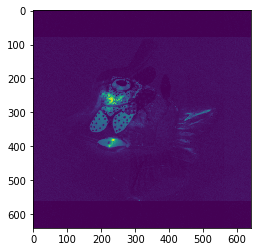

In [87]:
plt.imshow(_m_d[:,:,0].T)

In [79]:
I_D = _m_d * _diff_chrom

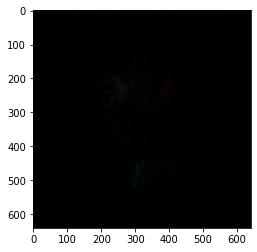

In [80]:
plt.imshow((_m_d * _diff_chrom * 255).astype('uint8'))

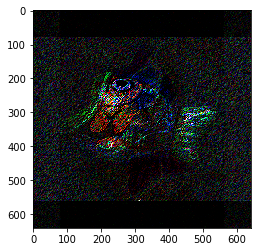

In [37]:
r_md, g_md, b_md  = cv2.split(_m_d)
_m_d_t = cv2.merge([r_md.T, g_md.T, b_md.T])
plt.imshow(_m_d_t)

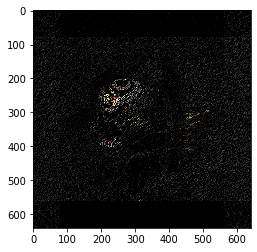

In [38]:
i = cv2.cvtColor((_m_d_t * _diff_chrom * 255).astype('uint8'), cv2.COLOR_HSV2RGB).astype('float32') / 255.0
plt.imshow(i)

img_ = np.copy(_diff_chrom)
img_[:,:,0] =  _m_d_t[:,:,0] * img_[:,:,0]
img_[:,:,1] = _m_d_t[:,:,1] * img_[:,:,1]
img_[:,:,2] = _m_d_t[:,:,2] * img_[:,:,2]
i = cv2.cvtColor((img_ * 255).astype('uint8'), cv2.COLOR_HSV2RGB)
plt.imshow(i)

In [57]:
a = np.array([True,False,True])
~a

array([False,  True, False])

In [83]:
m_mask = np.maximum(r_md, g_md, b_md).T
m_mask[~X_SVG] = 1.0
m3_mask = cv2.merge([m_mask,m_mask,m_mask])

In [124]:
r_md, g_md, b_md  = cv2.split(_m_d)
r_md[~X_SVG] = V[~X_SVG]
g_md[~X_SVG] = V[~X_SVG]
b_md[~X_SVG] = V[~X_SVG]
m3_mask = cv2.merge([r_md, g_md, b_md])

In [129]:
r_md, g_md, b_md  = cv2.split(_m_d)
r_md = r_md.T
g_md = g_md.T
b_md = b_md.T
r_md[~X_SVG] = V[~X_SVG]
g_md[~X_SVG] = V[~X_SVG]
b_md[~X_SVG] = V[~X_SVG]
m3_mask = cv2.merge([r_md, g_md, b_md])

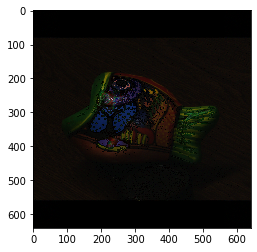

In [130]:
i = m3_mask *  _diff_chrom
plt.imshow(i)